In [1]:
import numpy as np
import pylab as plt
import torch
import torchvision
from models import ENet, UNet
import segmentation_models_pytorch as smp


def getMapDiff(ffunc, device, image_size=(1,512,512), fsize=(3,3)):
    assert len(image_size) == 3
    assert len(fsize) == 2
    itensor = torch.randn(1,image_size[0],image_size[1],image_size[2])
    with torch.no_grad():
        otensor = ffunc(itensor.to(device)).cpu()
    itensor2 = itensor.clone().detach()
    lx = image_size[1] // 2 - fsize[0]
    hx = image_size[1] // 2 + fsize[0]
    ly = image_size[2] // 2 - fsize[1]
    hy = image_size[2] // 2 + fsize[1]
    itensor2[0,0,lx:hx,ly:hy] = torch.randn(hx-lx,hy-ly) * 100
    assert torch.norm(itensor - itensor2) > 0
    with torch.no_grad():
        otensor2 = ffunc(itensor2.to(device)).cpu()
    odiff = torch.abs(otensor - otensor2)
    return np.mean(odiff.numpy()[0], axis=0)

IMAGE_SHAPE = (1,256,256)
FSHAPE = (8,8)

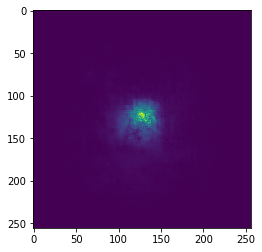

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = smp.Unet('densenet121', encoder_weights=None, in_channels=1, classes=4).eval().to(device)

diffmap = getMapDiff(lambda x : model(x), device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [9]:
x = torch.randn(1,1,256,256).to(device)
[y.shape for y in model.encoder(x)]

[torch.Size([1, 1, 256, 256]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 256, 64, 64]),
 torch.Size([1, 512, 32, 32]),
 torch.Size([1, 1024, 16, 16]),
 torch.Size([1, 1024, 8, 8])]

ResNet18 out feature map


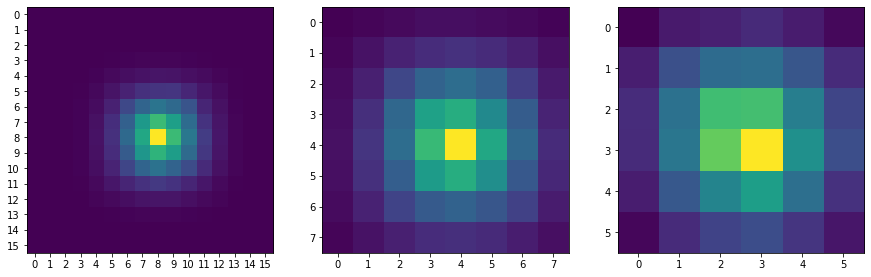

In [3]:
print('ResNet18 out feature map')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

diffmaps = []
for stride in [1, 2, 3]:
    net = torchvision.models.resnet18(pretrained=False)
    net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(stride, stride), padding=(3, 3), bias=False)
    backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'layer4': 'out'})
    backbone = backbone.eval().to(device)
    diffmaps += [getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)]

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(diffmaps[0])
ax[0].set_xticks(np.arange(diffmaps[0].shape[0]))
ax[0].set_yticks(np.arange(diffmaps[0].shape[1]))
ax[1].imshow(diffmaps[1])
ax[1].set_xticks(np.arange(diffmaps[1].shape[0]))
ax[1].set_yticks(np.arange(diffmaps[1].shape[1]))
ax[2].imshow(diffmaps[2])
ax[2].set_xticks(np.arange(diffmaps[2].shape[0]))
ax[2].set_yticks(np.arange(diffmaps[2].shape[1]))
plt.show()

DenseNet161 out feature map


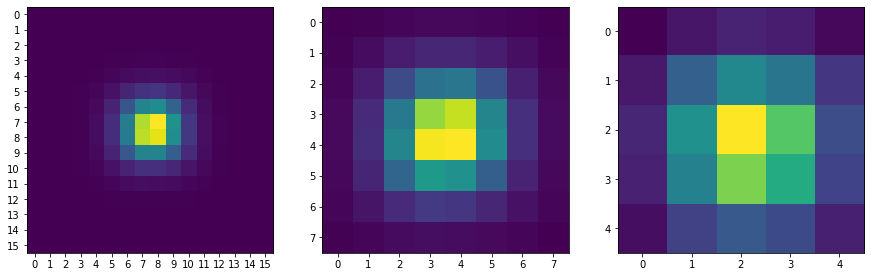

In [8]:
print('DenseNet161 out feature map')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

diffmaps = []
for stride in [1, 2, 3]:
    net = torchvision.models.densenet161(pretrained=False)
    net.features.conv0 = torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(stride, stride), padding=(3, 3), bias=False)
    
    backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'features': 'out'})
    backbone = backbone.eval().to(device)
    diffmaps += [getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)]

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(diffmaps[0])
ax[0].set_xticks(np.arange(diffmaps[0].shape[0]))
ax[0].set_yticks(np.arange(diffmaps[0].shape[1]))
ax[1].imshow(diffmaps[1])
ax[1].set_xticks(np.arange(diffmaps[1].shape[0]))
ax[1].set_yticks(np.arange(diffmaps[1].shape[1]))
ax[2].imshow(diffmaps[2])
ax[2].set_xticks(np.arange(diffmaps[2].shape[0]))
ax[2].set_yticks(np.arange(diffmaps[2].shape[1]))
plt.show()


In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
net.conv1[0] = torch.nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'conv5': 'out'})
classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(1024, 4)
model = torchvision.models.segmentation.DeepLabV3(backbone, classifier).eval().to(device)

diffmap = getMapDiff(lambda x : model(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
net.conv1[0] = torch.nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)
net.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'conv5': 'out'})
backbone = backbone.eval().to(device)
classifier = torchvision.models.segmentation.fcn.FCNHead(1024, 4)
model = torchvision.models.segmentation.FCN(backbone, classifier).eval().to(device)

diffmap = getMapDiff(lambda x : model(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
net = torchvision.models.resnet34(pretrained=False)
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'layer4': 'out'})

classifier = torchvision.models.segmentation.fcn.FCNHead(512, 4)
model = torchvision.models.segmentation.FCN(backbone, classifier).eval().to(device)

diffmap = getMapDiff(lambda x : model(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
net = torchvision.models.resnet34(pretrained=False)
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'layer4': 'out'})

classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(512, 4)
model = torchvision.models.segmentation.DeepLabV3(backbone, classifier).eval().to(device)

diffmap = getMapDiff(lambda x : model(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
net.conv1[0] = torch.nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'conv5': 'out'})
backbone = backbone.eval().to(device)

diffmap = getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = torchvision.models.densenet121(pretrained=False)
net.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
net.features.pool0 = torch.nn.MaxPool2d(1, 1)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'features': 'out'})
backbone = backbone.eval().to(device)

diffmap = getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
net

In [ ]:
net = torchvision.models.mobilenet_v2(pretrained=False)
net.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'features': 'out'})
backbone = backbone.eval().to(device)

diffmap = getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
net = torchvision.models.resnet18(pretrained=False)
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'layer4': 'out'})
backbone = backbone.eval().to(device)

diffmap = getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
net = torchvision.models.resnet34(pretrained=False)
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'layer4': 'out'})
backbone = backbone.eval().to(device)

diffmap = getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
net = torchvision.models.resnet50(pretrained=False)
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'layer4': 'out'})
backbone = backbone.eval().to(device)

diffmap = getMapDiff(lambda x : backbone(x)['out'], device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = ENet().eval().to(device)

diffmap = getMapDiff(lambda x : net(x), device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = UNet().eval().to(device)

diffmap = getMapDiff(lambda x : net(x), device, IMAGE_SHAPE, FSHAPE)
plt.imshow(diffmap)
plt.show()
